# Part 3: Genetic Algorithms 

`Lots of codes are inspired from the https://github.com/meiyi1986/tutorials/blob/master/notebooks/local-search-tsp.ipynb`

Traveling Salesman Problem (TSP) is to find a Hamiltonian cycle that visits each node in the graph exactly once.
**The goal is to minimise the total cost/distance of the cycle.**
In the tutorial, we have shown how to design local search to solve TSP. The local search is based on the 2-opt operator, and has two versions, one with best improvement and the other with first improvement.
**However, local search is easy to get stuck into poor local optima. Genetic algorithms are promising techniques to escape from local optima and reach better solutions.**

Requirement

You are required to develop a genetic algorithm to solve TSP.

1. Develop and implement the chromosome representation, fitness evaluation, crossover and mutation operators,and selection schemes.
2. Design the overall genetic algorithm framework, set the parameters, implement the algorithm and apply to the given `berlin52.tsp` instance. You can use the code in the tutorial to read the instance, preprocess the data and display the solutions.
3. In the report, clearly describe the genetic algorithm framework, chromosome representation, fitness evaluation, initialisation, crossover and mutation operators, and selection schemes.
4. In the report, draw the convergence curve of the performance, where the x-axis is the generation, and y-axis is the total cost of the best solution in the population in each generation.
5. In the report, compare the results with that obtained by the local search (by running the tutorial code), make deep and comprehensive discussions based on your observations, and draw conclusions.

In [20]:
import copy
from random import choice, sample
import random
import time
import numpy as np
import math
import matplotlib.pyplot as plt

print('-'*100)
print('-'*100)
print("Part 3: ")
print('-'*100)
print('-'*100)


class TSP: # for loading ds and calculating distance
    '''TSP dataset, load data from *.tsp files that contains:
        1. coord -> a set of locations with x, y coordinates 
        2. dist_mtx,cost_mtx -> a euclidean distance matrix based on coordinates 
        
    '''
    def __init__(self, filePath):
        self.coord = self.load_data(filePath)
        self.dist_mtx = self.euclidean_distance_matrix(self.coord)
        self.id_list = list(self.coord.keys())
        self.n = len(self.id_list)
        self.cost_mtx = self.dist_mtx 

    # load .tsp data
    # obtained from https://github.com/meiyi1986/tutorials/blob/master/notebooks/local-search-tsp.ipynb
    def load_data(self,file):
        """
        Read a TSP instance from a .tsp file, and returns the coordinates.
        :param file: the .tsp file.
        :return: coordinates
        """
        f = open(file, "r")
        # Skip the first information rows until "NODE_COORD_SECTION" is seen
        line = f.readline()
        while not line.__contains__("NODE_COORD_SECTION"):
            line = f.readline()

        # Read the coordinate section
        coord = {}

        line = f.readline()
        while not line.__contains__("EOF"):
            line_elements = line.split()
            id = int(line_elements[0])
            x = float(line_elements[1])
            y = float(line_elements[2])
            coord[id] = [x, y]
            line = f.readline()
        f.close()
        return coord

    # Then, we obtain the cost matrix of the TSP instance, which is the Euclidean distanc matrix. 
    def euclidean_distance_matrix(self,coord):
        """
        Calculate the Euclidean distance matrix based on the coordinates.
        """
        id_list = list(coord.keys())
        dist_mtx = np.zeros((max(id_list)+1, max(id_list)+1))
        for id1 in coord.keys():
            [x1, y1] = coord[id1]
            for id2 in coord.keys():
                if id1 == id2:
                    continue
                
                [x2, y2] = coord[id2]
                dist = round(math.sqrt((x2 - x1) * (x2 - x1) + (y2 - y1) * (y2 - y1)))
                dist_mtx[id1, id2] = dist
        return dist_mtx
    
class Individual: # for Individual solution
    """
    route of the TSP, which is the chromosome representation, a possible solution to TSP.
    Part of the code is inspired by : https://github.dev/lccasagrande/TSP-GA
    """
    
    def __init__(self, tour:list, ds:TSP):
        """tour is the set of gene, which is the list of the id of the coord in the TSP.
        For example, [1,2,3,1] is a list of id, do not have the duplicates, the start and end is the same , which is the Hamiltonian cycle.

        Args:
            tour(list): a set of ids of the coord in the TSP.
            ds (TSP): the belonged TSP dataset, used to calculate the travel cost and fitness.
        """
        self.tour = tour
        self.ds = ds
        self.__reset_params()
        
    # def calc_tour_cost(tour, cost_mtx):
    #     return sum([cost_mtx[tour[i], tour[i+1]] for i in range(len(tour)-1)])

    def get_travel_tour_cost(self):
        """
        Calculate the travel cost of the individual.
        """
        self.__travel_cost = sum([self.ds.cost_mtx[self.tour[i], self.tour[i+1]] for i in range(len(self.tour)-1)])
        # due to the hamiltonian cycle, the last and first element is the same
        self.__travel_cost += self.ds.cost_mtx[self.tour[-1], self.tour[0]]
        return self.__travel_cost
    
    def get_fitness(self):
        """
        Calculate the fitness of the individual.
        It is inspired by : https://github.dev/lccasagrande/TSP-GA
        """
        self.__fitness = 1 / self.get_travel_tour_cost() # normalize the fitness
        return self.__fitness
        
    def __reset_params(self):
        # assert len(self.tour) > len(self.ds.id_list)
        assert len(set(self.tour)) == len(self.ds.id_list)
        self.__travel_cost = 0
        self.__fitness = 0
        
        self.get_travel_tour_cost()
        self.get_fitness()
        

    def apply_mutation(self, mutation_rate:float = 0.1):
        """Apply the mutation to the individual by Swaping 2 genes in the individual.
        Args:
            mutation_rate (float): the mutation rate.
        """
        for i in range(len(self.tour)):
            if np.random.random() < mutation_rate:
                # -1since head is the same as the tail
                j = np.random.randint(1, len(self.tour)-1)
                if j == 0 or j == len(self.tour)-1:
                    continue
                self.tour[i], self.tour[j] = self.tour[j], self.tour[i]
            
        self.__reset_params()
        
    def plot_tour(self, title:str):
        """
        Function for plotting a TSP tour on a 2D figure.

        :param tour: The TSP tour, which is a list of nodes.
        :param coord: Dictionary of {id: [x, y]} coordinates for each node.
        :param title: Plot title.
        """
        coord = self.ds.coord
        px = [coord[id][0] for id in coord.keys()]
        py = [coord[id][1] for id in coord.keys()]

        # Set axis too slightly larger than the set of x and y
        min_x, max_x, min_y, max_y = min(px), max(px), min(py), max(py)
        center_x = (min_x + max_x) / 2
        center_y = (min_y + max_y) / 2

        width = (max(px) - min(px)) * 1.1
        height = (max(py) - min(py)) * 1.1

        min_x = center_x - width / 2
        max_x = center_x + width / 2
        min_y = center_y - height / 2
        max_y = center_y + height / 2

        plt.xlim(min_x, max_x)
        plt.ylim(min_y, max_y)
        
        # Plot the [px, py] points
        for [x, y] in coord.values():
            plt.plot(x, y, 'co', markersize = 5)
        
        # Plot the tour
        for i in range(0, len(self.tour)-1):
            [x1, y1], [x2, y2] = coord[self.tour[i]], coord[self.tour[i + 1]]
            plt.plot([x1, x2], [y1, y2], color = 'c')
            
        # TODO:might need to delete this additioal line
        # connect the 1st and last node of the tour, constraint of the Hamiltonian cycle
        plt.plot([coord[self.tour[0]][0], coord[self.tour[-1]][0]], [coord[self.tour[0]][1], coord[self.tour[-1]][1]], color = 'c')

        plt.title(title+'\nTravel cost: '+str(self.get_travel_tour_cost())+'\nFitness: '+str(self.get_fitness()))
        plt.show()
    
    
    @classmethod
    def get_a_random_individual(cls,ds:TSP,start_end_node_id:int = 1):
        """
        Create a random individual instance for the TSP.
        The start_end_node is the id of the start and end node, it is used to address the symmetry problem.
        """
        # tempTour =  np.random.permutation(ds.id_list)
        tempTour= np.array(ds.id_list)
        np.random.shuffle(tempTour)
        # remove start_end_node from the tour
        tempTour = np.delete(tempTour, np.where(tempTour == start_end_node_id))
        assert len(tempTour) == len(set(tempTour))
        # add start_end_node to the tour as the head 
        tempTour = np.insert(tempTour, 0, start_end_node_id)
        tempTour =  np.append(tempTour, start_end_node_id)
        assert tempTour[0] == tempTour[-1]
        assert len(tempTour) == len(ds.id_list)+1
        return cls(tempTour.tolist(), ds)
    
    @classmethod
    def get_fittest_from_population(cls,population:list):
        """
        Get the fittest individual from the population.
        """
        return max(population, key=lambda x: x.get_fitness())
    
    @classmethod
    def tournament_select_one_from_population(cls,population:list):
        """
        Get one individual from the population, based on the heurstic.
        """
        population_copy = copy.deepcopy(population)
        # sort it based on the fitness, high to low
        population_copy.sort(key=lambda x: x.get_fitness(), reverse=True)
        # assign the probablity to each individual according to the fitness
        fitness_sum = sum([x.get_fitness() for x in population_copy])
        fitness_prob = [x.get_fitness() / fitness_sum for x in population_copy]
        # get one individual from the population, based on the probablity
        return np.random.choice(population_copy, p=fitness_prob)
        
        
def apply_crossOver(parent1:Individual, parent2:Individual) -> Individual:
    """
    Apply the partially mapped crossover.
    Args:
        parent1 (Individual): the first parent.
        parent2 (Individual): the second parent.
    """
    assert len(parent1.tour) == len(parent2.tour)
    postCheckLen = len(parent1.tour)
    
    temp_p1tour,temp_p2tour = list(set(copy.deepcopy(parent1.tour))), list(set(copy.deepcopy(parent2.tour)))
    temp_p1tour.remove(1)
    temp_p2tour.remove(1)

    # child = [None for _ in range(len(temp_p1tour)-1)]
    # # assign tour except the last node to the child
    # parent1_tour = copy.deepcopy(parent1).tour[:-1]
    # parent2_tour = copy.deepcopy(parent2).tour[:-1]
    child = [None for _ in range(len(temp_p1tour))]
    
    # copy a segment from a parent to the child
    # seg_len = len(child)//2
    seg_len = np.random.randint(low=5, high=len(temp_p1tour)//2)
    seg_start_idx = np.random.randint(0, len(child) - seg_len -1) 
    seg_end_idx = seg_start_idx + seg_len
    # copy the segment from the first parent to the child
    for i in range(seg_start_idx, seg_end_idx):
        child[i] = temp_p1tour[i]
    # fullfill the child with the second parent
    j = 0
    for i in range(0,len(temp_p2tour)):
        if child[i] is None:
            while j >= len(temp_p2tour) or temp_p2tour[j] in child :
                j+=1
            child[i] = temp_p2tour[j]
            j+=1
    assert len(set(child)) == len(child) , f"got dup: {child}"
    assert len(child) == postCheckLen-2
    # # add the last node to the child
    child.append(1)
    child.insert(0,1)
    # assert whether child got duplicates
    assert child[0]==child[-1],f"SHould be same: 0:{child[0]}, -1: {child[-1]}"
    assert len(child) == postCheckLen, "child tour length not equal to parent tour length"
    return Individual(child, parent1.ds)
    

# def selection(population:list(Individual), ds:TSP):
#     """
#     Selection the best individual from the population.
#     Args:
#         population (list(Individual)): the population of the TSP.
#         ds (TSP): the belonged TSP dataset, used to calculate the travel cost and fitness.
#     """
#     # sort the population by fitness
#     population.sort(key = lambda x: x.get_fitness(), reverse = True)
#     # return the best individual
#     return population[0]




----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Part 3: 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


#### local search TSP , code are  modifed from Yi 

In [21]:

# def local_search_tsp(coord, cost_mtx, initialisation, nb_selection, seed):
def local_search_tsp(individual_input : Individual, nb_selection):
    '''
    The local search framework for solving TSP.
    :param coord, cost_mtx: The coordinates of the nodes and the cost matrix.
    :param initialisation: The initialisation method.
    :param nb_selection: The neighbour selection method.
    :param seed: the random seed, if the local search is a stochastic search.
    :return: The final tour and the log, which stores the elapsed time and best cost so far after each iteration.
    '''
    
    log = {'time': [], 'cost': []} # The log [elapse_time, best_cost]
    start = time.time()
    
    # sol, sol_cost = initialisation(coord, cost_mtx, seed)
    sol, sol_cost = individual_input.tour,individual_input.get_travel_tour_cost()
    improved = True
    while improved:
        improved = False
        individual_temp = nb_selection(individual_input)
        nb, nb_cost = individual_temp.tour, individual_temp.get_travel_tour_cost()
        
        if sol_cost - nb_cost > 0.0000000001:
            sol, sol_cost = nb, nb_cost
            improved = True

        end = time.time()
        log['time'].append(end-start)
        log['cost'].append(sol_cost)
    return Individual(sol, individual_input.ds)
    # return sol, sol_cost, log


def two_opt_first_improvement(individualTour:Individual) -> Individual:
    """Modify from the Yi's jupyter notebook. It explore the neighborhood of the current tour and return the one as soon as it is found to be better than the given current individualTour solution.

    Args:
        individualTour (Individual): the given current individualTour solution.

    Returns:
        Individual: the neighbor of the current individualTour solution
    """
    tour, tour_cost, coord, cost_mtx = individualTour.tour, individualTour.get_travel_tour_cost(), individualTour.ds.coord, individualTour.ds.cost_mtx

    nb, nb_cost = tour, tour_cost
    
    # Since tour[0] = tour[-1], we doe not allow 2-opt between [0, 1] and [len-2, len-1]
    n1, n2 = tour[0], tour[1]
    for j in range(2,len(tour)-2):
        # The second removed edge [n3, n4]
        n3, n4 = tour[j], tour[j+1]

        # Remove old edges [n1, n2] and [n3, n4], and add new edges [n1, n3] and [n2, n4]
        # Calculate the cost change
        cost_change = cost_mtx[n1, n2] + cost_mtx[n3, n4] - cost_mtx[n1, n3] - cost_mtx[n2, n4]

        if cost_change > 0.0000000001:
            # Change the tour, reverse the part [1, j]
            nb[1:j+1] = nb[1:j+1][::-1]
            nb_cost -= cost_change
            # return nb, nb_cost
            return Individual(nb, individualTour.ds)
    
    # Enumerate from tour[1]. In this case, j can go to the end of the tour
    for i in range(1,len(tour)-2):
        # The first removed edge [n1, n2]
        n1, n2 = tour[i], tour[i+1]

        for j in range(i+2,len(tour)-1):
            # The second removed edge [n3, n4]
            n3, n4 = tour[j], tour[j+1]
            
            # Remove old edges [n1, n2] and [n3, n4], and add new edges [n1, n3] and [n2, n4]
            # Calculate the cost change
            cost_change = cost_mtx[n1, n2] + cost_mtx[n3, n4] - cost_mtx[n1, n3] - cost_mtx[n2, n4]
            
            if cost_change > 0.0000000001:
                # Change the tour, reverse the part [i+1, j]
                nb[i+1:j+1] = nb[i+1:j+1][::-1]
                nb_cost -= cost_change
                return Individual(nb, individualTour.ds)
                # return nb, nb_cost
    
    return Individual(nb, individualTour.ds)
    # return nb, nb_cost

# def two_opt_best_improvement(tour, tour_cost, coord, cost_mtx, seed):
def two_opt_best_improvement(individualTour:Individual) -> Individual:
    tour, tour_cost, coord, cost_mtx = individualTour.tour, individualTour.get_travel_tour_cost(), individualTour.ds.coord, individualTour.ds.cost_mtx
    
    nb, nb_cost = tour, tour_cost
    best_change = 0
    best_i = None
    best_j = None
    
    # Since tour[0] = tour[-1], we doe not allow 2-opt between [0, 1] and [len-2, len-1]
    n1, n2 = tour[0], tour[1]
    for j in range(2,len(tour)-2):
        # The second removed edge [n3, n4]
        n3, n4 = tour[j], tour[j+1]

        # Remove old edges [n1, n2] and [n3, n4], and add new edges [n1, n3] and [n2, n4]
        # Calculate the cost change
        cost_change = cost_mtx[n1, n2] + cost_mtx[n3, n4] - cost_mtx[n1, n3] - cost_mtx[n2, n4]

        if cost_change > best_change:
            best_change = cost_change
            best_i = 0
            best_j = j
    
    # Enumerate from tour[1]. In this case, j can go to the end of the tour
    for i in range(1,len(tour)-2):
        # The first removed edge [n1, n2]
        n1, n2 = tour[i], tour[i+1]

        for j in range(i+2,len(tour)-1):
            # The second removed edge [n3, n4]
            n3, n4 = tour[j], tour[j+1]
            
            # Remove old edges [n1, n2] and [n3, n4], and add new edges [n1, n3] and [n2, n4]
            # Calculate the cost change
            cost_change = cost_mtx[n1, n2] + cost_mtx[n3, n4] - cost_mtx[n1, n3] - cost_mtx[n2, n4]
            
            if cost_change > best_change:
                best_change = cost_change
                best_i = i
                best_j = j
    
    # Actually change the tour if we found an improvement
    if best_change > 0.0000000001:
        # Change the tour, reverse the part [best_i+1, best_j]
        nb[best_i+1:best_j+1] = nb[best_i+1:best_j+1][::-1]
        nb_cost -= best_change

    return Individual(nb, individualTour.ds)
    # return nb, nb_cost


### framework

In [22]:
from http.client import LineTooLong
from random import sample
import random
import time # for time measurement

def initialize_population(ds:TSP, size):# -> list(Individual):
    """
    Initialize the population of the TSP.
    Args:
        ds (TSP): the belonged TSP dataset, used to calculate the travel cost and fitness.
        size (int): the size of the population.
    """
    population = []
    # repeat until the population is full
    # this initialisation address the issue of symmetry, so use while loop
    while len(population) < size:
        population.append(Individual.get_a_random_individual(ds))
    return population

def evolve_new_population(population:list, ds:TSP,elitism_precentage:float = 0.05) :#-> list(Individual):
    """
    Evolve the population of the TSP.
    Args:
        population (list(Individual)): the population of the TSP.
        ds (TSP): the belonged TSP dataset, used to calculate the travel cost and fitness.
    """
    new_generation = []
    population_size = len(population)
    elitism_size = int(elitism_precentage * population_size) # default 5% of the population size
    # apply the Elitism
    for _ in range(elitism_size):
        fittest_ind = Individual.get_fittest_from_population(population)
        new_generation.append(fittest_ind)
        # # remove it from the original population
        # population.remove(fittest_ind) 
    
    for _ in range(elitism_size, population_size):
        # select two individuals as parents from the old population
        parent1 = Individual.tournament_select_one_from_population(population)
        parent2 = Individual.tournament_select_one_from_population(population)
        # apply the crossover to generate  new individual
        child1= apply_crossOver(parent1, parent2)
        # each child has a prob to mutate
        child1.apply_mutation(0.1)
        # apply 2opt local seach, the implementation is obatined from Yi's tutorial
        probability = random.random()        
        if probability < 0.2:
            child1 = local_search_tsp(child1,two_opt_best_improvement)
        elif probability < 0.8:
            child1 = local_search_tsp(child1,two_opt_first_improvement)
        new_generation.append(child1)
    assert len(new_generation) == population_size, "Old gen size should be the same as original population size"
    return new_generation
        

def run_genetic_algorthim_framework(ds:TSP, pop_size, max_gens, gen_not_improved_threshold): 
    """
    The genetic algorithm framework.
    """
    # initialize the population of the TSP.
    individuals = initialize_population(ds, pop_size)
    best_individiual = Individual.get_fittest_from_population(individuals)
    start_time,gen_not_improved_counter,gen_counter = time.time(),0,0
    
    logs_history = {'cost': [], 'time': [start_time]}
    # the stop cretia is the number of generations
    while gen_counter < max_gens and gen_not_improved_counter < gen_not_improved_threshold:
        individuals = evolve_new_population(individuals, ds) # elitism,selection,crossover,mutation,LS
        temp_best = Individual.get_fittest_from_population(individuals)
        
        if temp_best.get_fitness() > best_individiual.get_fitness():
            # min_cost = temp_best.get_fitness()
            best_individiual = temp_best
            gen_not_improved_counter = 0
        else: 
            gen_not_improved_counter += 1
            
        gen_counter += 1
        print(f"Current generation: {gen_counter} \nCurrent best cost: {best_individiual.get_travel_tour_cost()}\nTime Spent: {time.time() - start_time}\ngen_not_improved_counter: {gen_not_improved_counter}")
        print('-'*60)
        logs_history['cost'].append(best_individiual.get_travel_tour_cost())
        logs_history['time'].append(time.time()- start_time)
    logs_history['best_individual'] = best_individiual
    logs_history['generations'] = gen_counter
    
    return logs_history

In [30]:
berlin52 = TSP('./tsp/berlin52.tsp')
logs_history = run_genetic_algorthim_framework(berlin52, pop_size=100, max_gens=300, gen_not_improved_threshold=160)


Current generation: 1 
Current best cost: 7734.0
Time Spent: 4.831132411956787
gen_not_improved_counter: 0
------------------------------------------------------------
Current generation: 2 
Current best cost: 7734.0
Time Spent: 13.1505606174469
gen_not_improved_counter: 1
------------------------------------------------------------
Current generation: 3 
Current best cost: 7542.0
Time Spent: 21.03972816467285
gen_not_improved_counter: 0
------------------------------------------------------------
Current generation: 4 
Current best cost: 7542.0
Time Spent: 29.10911250114441
gen_not_improved_counter: 1
------------------------------------------------------------
Current generation: 5 
Current best cost: 7542.0
Time Spent: 37.04616641998291
gen_not_improved_counter: 2
------------------------------------------------------------
Current generation: 6 
Current best cost: 7542.0
Time Spent: 45.02038812637329
gen_not_improved_counter: 3
------------------------------------------------------

KeyboardInterrupt: 

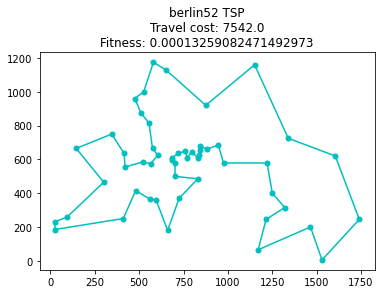

The best individual is <__main__.Individual object at 0x7fa83c406d60>


In [ ]:
logs_history['best_individual'].plot_tour("berlin52 TSP")
# print other information
# print(f"The best individual is {logs_history['best_individual']}")


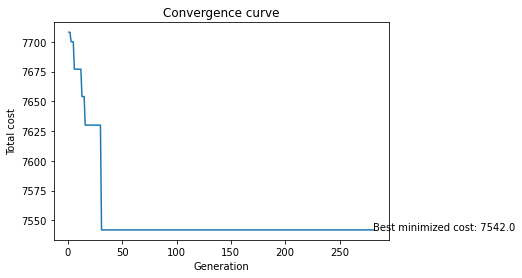

In [ ]:
def plot_convergence_curve(logs:list):
    """Plot the convergence curve of the performance where the x-axis is the generation, and the y-axis is the total cost of the best solution in the population in each generation.
    
    From: https://github.dev/lccasagrande/TSP-GA
    """
    # only plot the first 70 generations
    x = np.arange(1, logs['generations']+1)
    y = np.array(logs['cost'])
    
    
    plt.title('Convergence curve')
    plt.xlabel('Generation')
    plt.ylabel('Total cost')
    plt.plot(x, y, '-')
    plt.text(x[-1], y[-1], 'Best minimized cost: ' + str(y[-1]))
    
plot_convergence_curve(logs_history)

In [33]:
a280 = TSP('./tsp/a280.tsp') # optimal solution is 2579
logs_history = run_genetic_algorthim_framework(a280, pop_size=10, max_gens=300, gen_not_improved_threshold=100) 

Current generation: 1 
Current best cost: 2726.0
Time Spent: 24.527929067611694
gen_not_improved_counter: 0
------------------------------------------------------------
Current generation: 2 
Current best cost: 2726.0
Time Spent: 66.51569819450378
gen_not_improved_counter: 1
------------------------------------------------------------
Current generation: 3 
Current best cost: 2709.0
Time Spent: 108.46153998374939
gen_not_improved_counter: 0
------------------------------------------------------------
Current generation: 4 
Current best cost: 2709.0
Time Spent: 142.8103005886078
gen_not_improved_counter: 1
------------------------------------------------------------
Current generation: 5 
Current best cost: 2709.0
Time Spent: 191.0735058784485
gen_not_improved_counter: 2
------------------------------------------------------------
Current generation: 6 
Current best cost: 2683.0
Time Spent: 233.57378721237183
gen_not_improved_counter: 0
--------------------------------------------------

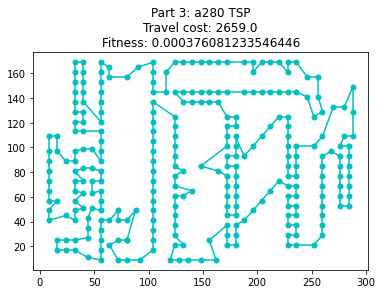

In [37]:
logs_history['best_individual'].plot_tour("Part 3: a280 TSP")


# Part 4: GP

A greedy heuristic for the TSP is the nearest neighbour heuristic. Starting with an arbitrary node, at each step it visits the nearest node to the current node (ties are broken randomly), until all the nodes have been visited.

However, the nearest neighbour heuristic can be poor, as it can visit all the nodes around a node and leave
itisolated, and finally visit it through a very long path.
To address this issue, we can use genetic programming (GP), as a hyper-heuristic, to learn potentially better
selection criteria than always visiting the nearest neighbour.
The main idea of GP hyper-heuristic is to evolve a program h(node), which calculates the priority of a job based
on its attributes. Specifically, the TSP heuristic based on a GP program h(node) is as follows


Step 1. Let S = [v0], where v0 is an arbitrary node. V ′ = V \v0.
Step 2. For each node in v ∈V ′, calculate the priority value h(v).
Step 3. Select the next node vnext as the one with the maximal priority value in V ′.
Step 4. Append vnext to the end of S, V ′ = V \vnext.
Step 5. If V ′ = ∅, S = [S, v0], stop. Otherwise, go back to Step 2.


Requirements
In this part, you are required to design and implement a GP hyper-heuristic algorithm to automatically evolve the
priority function for the TSP heuristic. Specifically, you need to
1. Design proper terminal (node attributes) and function sets of the GP algorithm.
2. Develop and implement the fitness evaluation of a GP individual/program based on the steps described above.
3. Set proper GP parameters, such as population size, crossover, mutation and reproduction rates, number of
generations, maximal tree depth, etc.
4. Run the GP algorithm on the berlin52.tsp instance with 3 different random seeds. For each run, report the
following in the report:
•The best GP program of the run (the tree);
•Draw the TSP solution generated by the best GP program and its total cost;
•Compare with the solution generate by the nearest neighbour heuristic and make discussions.
•Apply the best GP program to the a280.tsp instance, and draw the generated solution and its total
cost. Compare the solution with that generated by the nearest neighbour heuristic and make deep and
comprehensive discussions based on your observations



In [ ]:
print('-'*100)
print('-'*100)
print("Part 4: ")
print('-'*100)
print('-'*100)

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Part 4: 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
